In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set
from avgn.visualization.quickplots import draw_projection_plots

### Collect data

In [4]:
DATASET_ID = 'canary_segmented'

In [5]:
from avgn.utils.hparams import HParams
from avgn.dataset import DataSet

In [6]:
hparams = HParams()
# create a dataset object
dataset = DataSet(DATASET_ID, hparams = hparams)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 182 tasks      | elapsed:    6.7s


[Parallel(n_jobs=-1)]: Done 2320 out of 2320 | elapsed:    7.9s finished


In [7]:
from avgn.visualization.projections import (
    scatter_projections,
    draw_projection_transitions,
)

In [8]:
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'canary.pickle'
df_loc

PosixPath('/local/home/tsainbur/github_repos/avgn_paper/data/syllable_dfs/canary_segmented/canary.pickle')

In [9]:
syllable_df = pd.read_pickle(df_loc)

### add label data to df

In [10]:
syllable_df['phrase'] = None
syllable_df['med_time'] = (syllable_df.start_time + syllable_df.end_time)/2

In [11]:
from joblib import Parallel, delayed
def get_phrase_labels(key_data, syllable_df_key):
    for st, ed, lab in zip(
        key_data["start_times"], key_data["end_times"], key_data["labels"]
    ):
        syllable_df_key.loc[
            (syllable_df_key.med_time >= st)
            & (syllable_df_key.med_time <= ed),
            "phrase",
        ] = lab
    return syllable_df_key

In [12]:
syllable_dfs = Parallel(n_jobs=-1)(
    delayed(get_phrase_labels)(
        dataset.data_files[key].data["indvs"][list(dataset.data_files[key].data["indvs"].keys())[0]]["phrases"],
        syllable_df[syllable_df.key == key]
    ) for key in tqdm(syllable_df.key.unique())
)

E1024 20:09:56.453918 140614252177152 _base.py:627] exception calling callback for <Future at 0x7fe1b172ae80 state=finished returned list>
Traceback (most recent call last):
  File "/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/joblib/parallel.py", line 309, in __call__
    self.parallel.dispatch_next()
  File "/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/joblib/parallel.py", line 731, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/joblib/parallel.py", line 754, in dispatch_one_batch
    self._pickle_cache)
  File "/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/joblib/parallel.py", line 210, in __init__
    self.items = list(iterator_slice)
  File "<ipython-input-12-be54fc5146c0>", li

In [13]:
syllable_df = pd.concat(syllable_dfs)
syllable_df = syllable_df[syllable_df.phrase.values!=None]

In [14]:
syllable_df[:3]

,start_time,end_time,indv,indvi,key,audio,rate,spectrogram,phrase,med_time
0,0.000,0.036,bird3,0,bird3_0525_2004_04_19_16_06,"[-0.013927590325060985, -0.09374820877158284, ...",48000,"[[0, 0, 0, 0, 0, 0, 206, 254, 90, 0, 18, 0, 0,...",2,0.0180
1,0.101,0.136,bird3,0,bird3_0525_2004_04_19_16_06,"[-0.08033924279200529, -0.1427361110642931, -0...",48000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2,0.1185
2,0.208,0.247,bird3,0,bird3_0525_2004_04_19_16_06,"[0.20502230290406648, 0.16692246300221994, 0.1...",48000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2,0.2275


In [16]:
len(syllable_df)

482608

In [17]:
del syllable_df['audio']

In [18]:
syllable_df[:3]

,start_time,end_time,indv,indvi,key,rate,spectrogram,phrase,med_time
0,0.000,0.036,bird3,0,bird3_0525_2004_04_19_16_06,48000,"[[0, 0, 0, 0, 0, 0, 206, 254, 90, 0, 18, 0, 0,...",2,0.0180
1,0.101,0.136,bird3,0,bird3_0525_2004_04_19_16_06,48000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2,0.1185
2,0.208,0.247,bird3,0,bird3_0525_2004_04_19_16_06,48000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2,0.2275


In [ ]:
syllable_df.to_pickle(df_loc)

bird3 127752


8


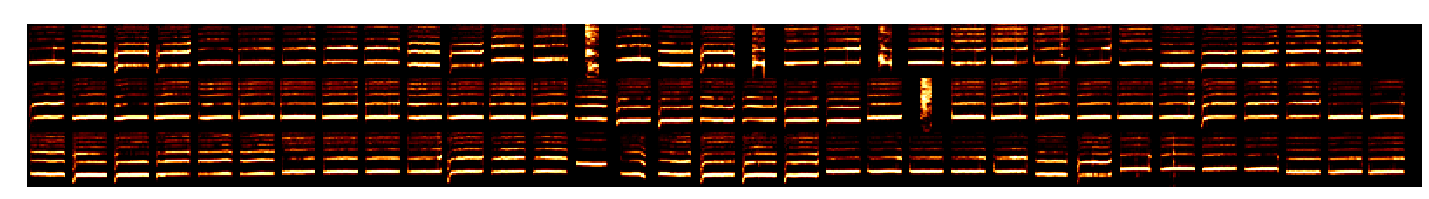

4


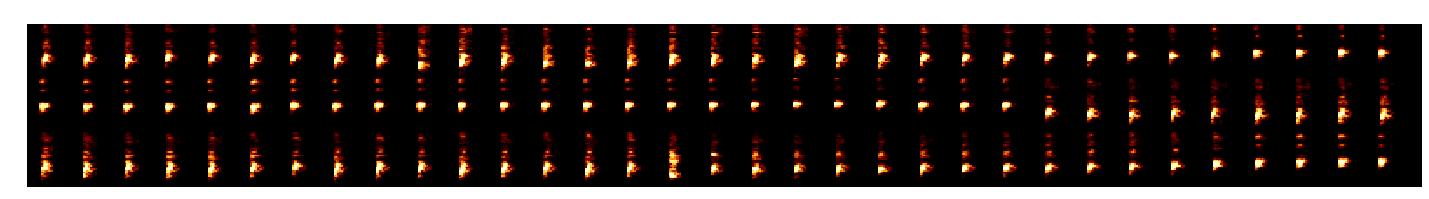

17


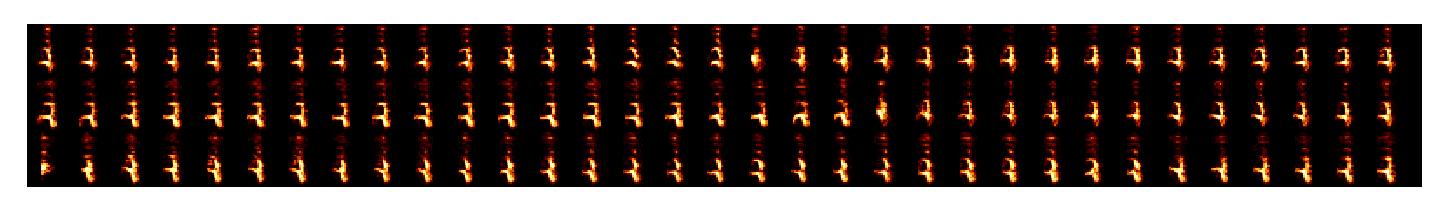

13


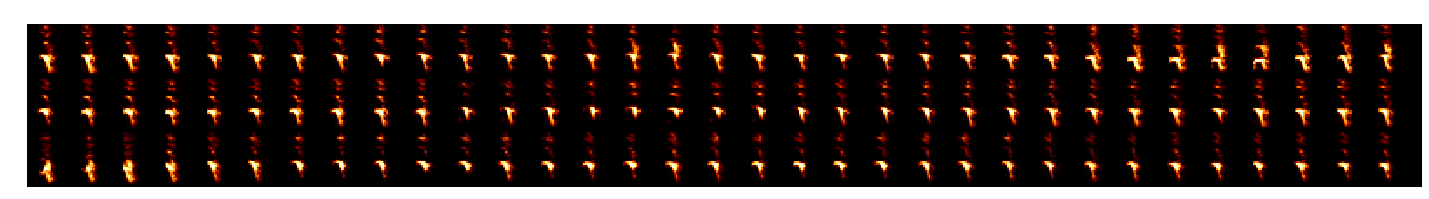

22


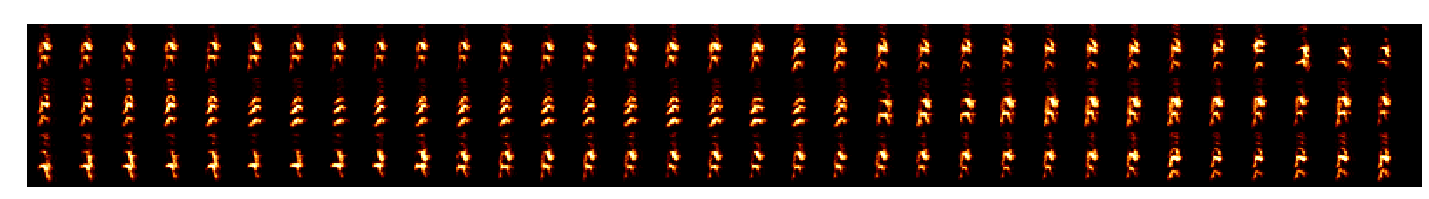

6


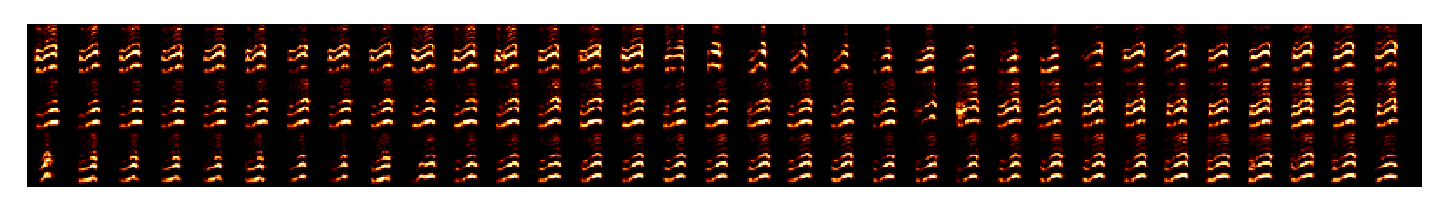

3


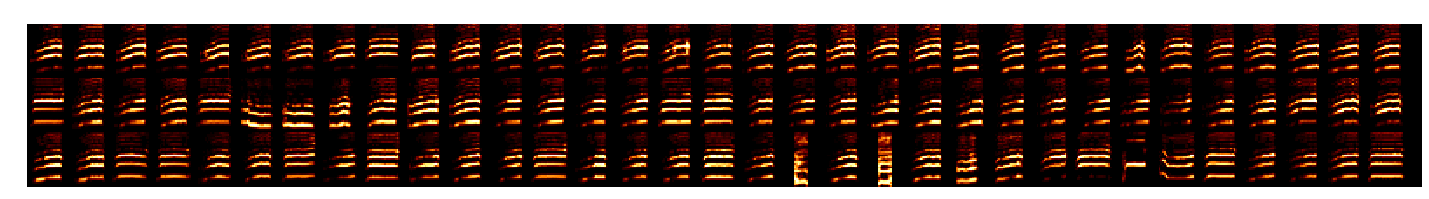

7


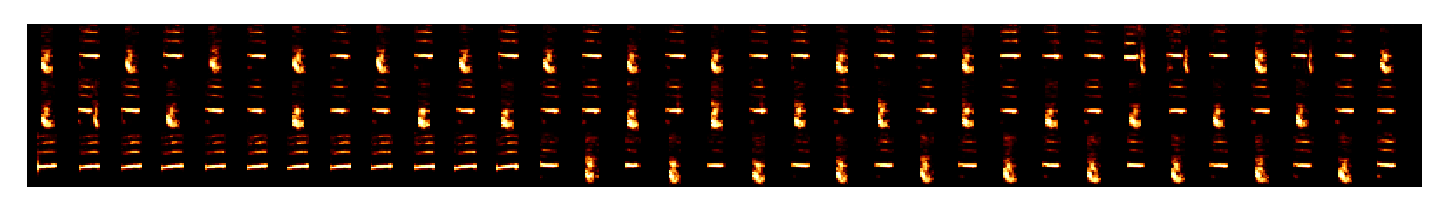

18


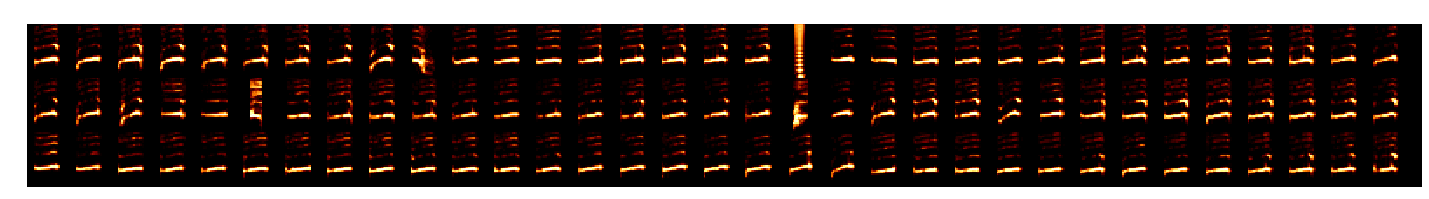

19


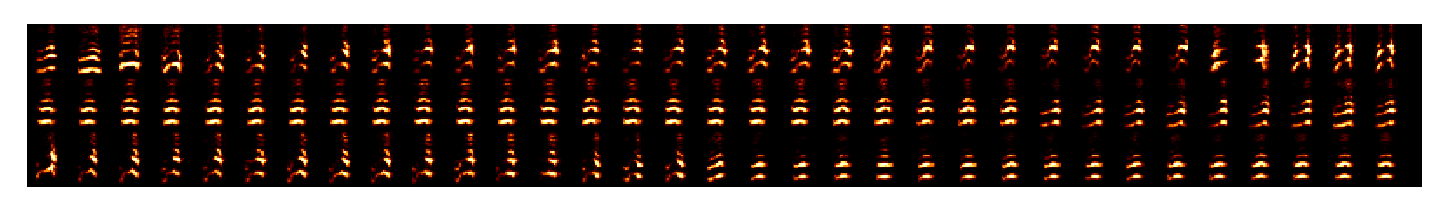

5


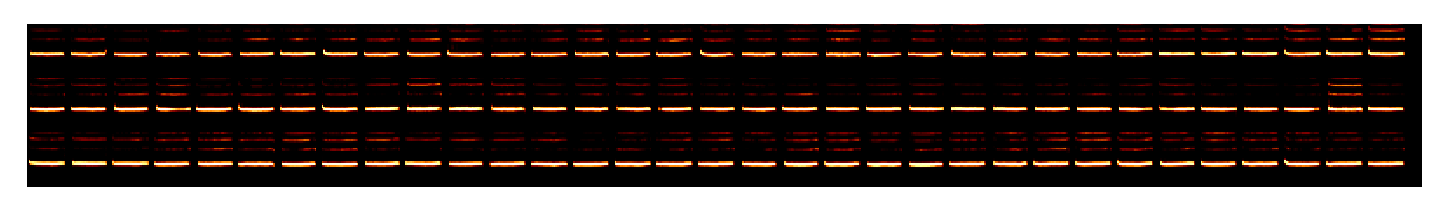

14


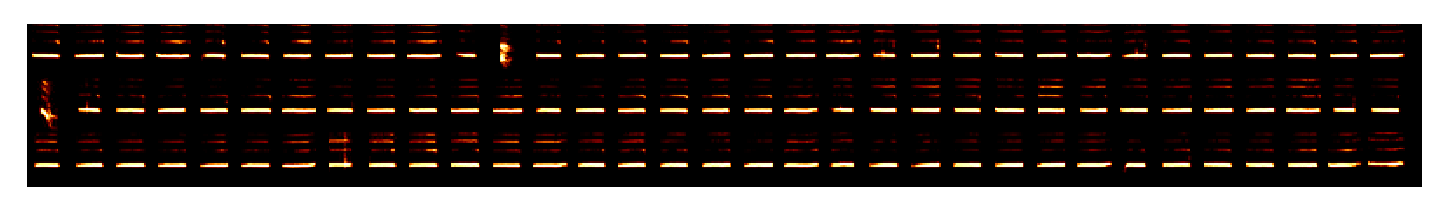

21


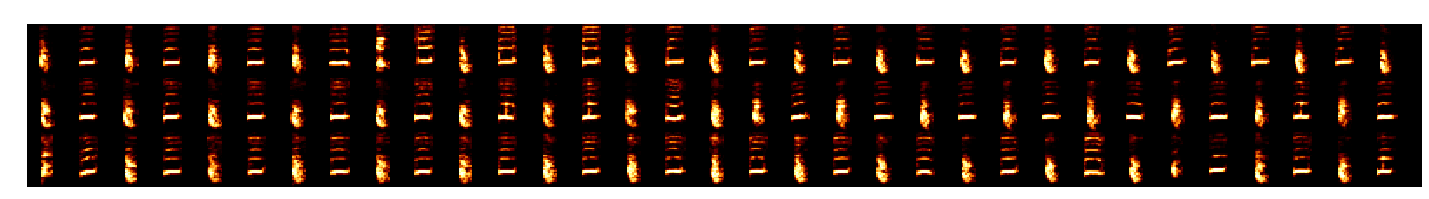

20


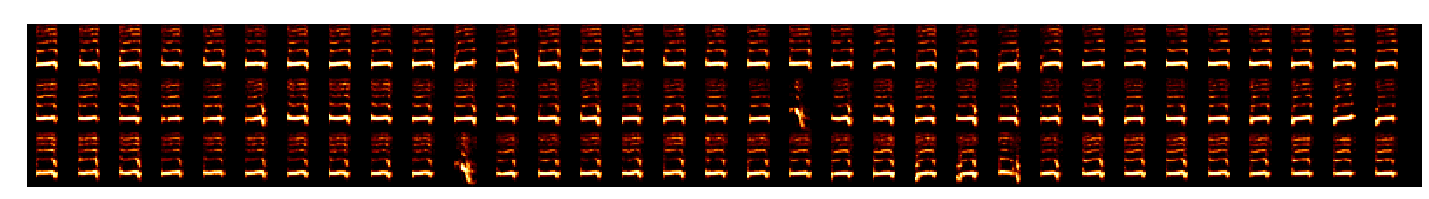

16


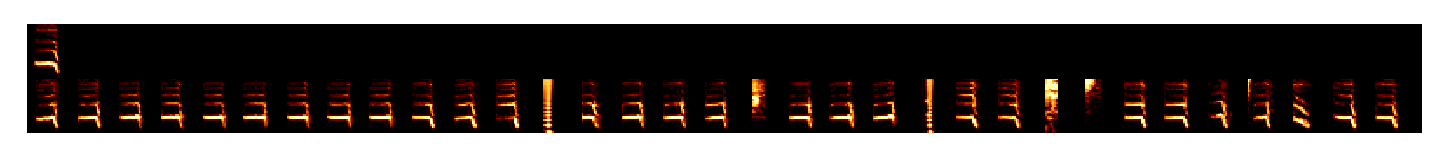

11


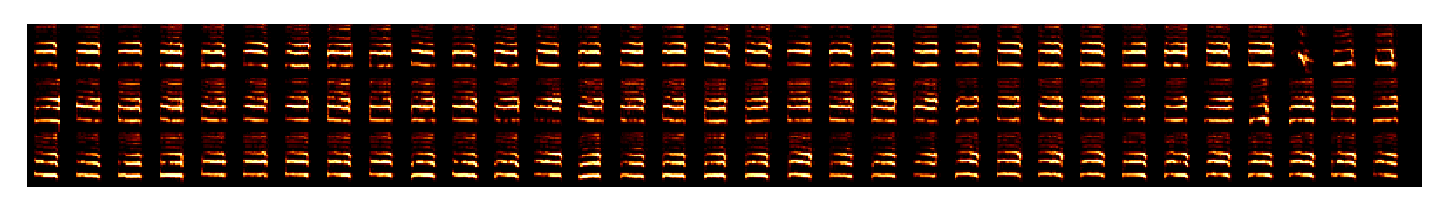

2


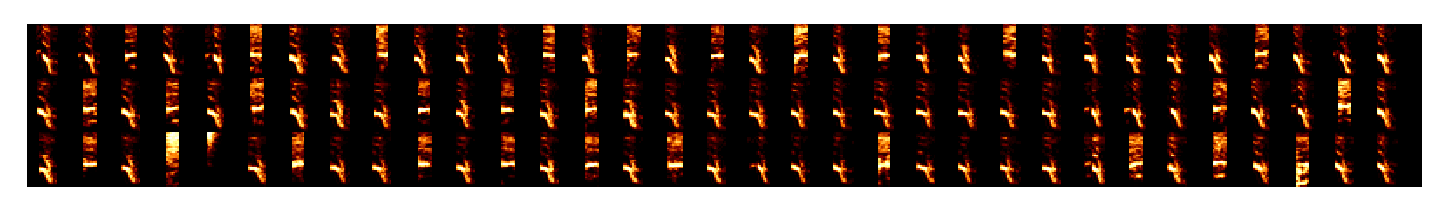

9


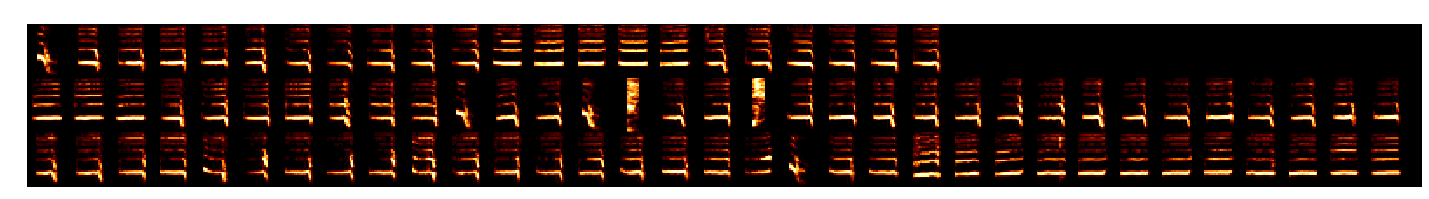

1


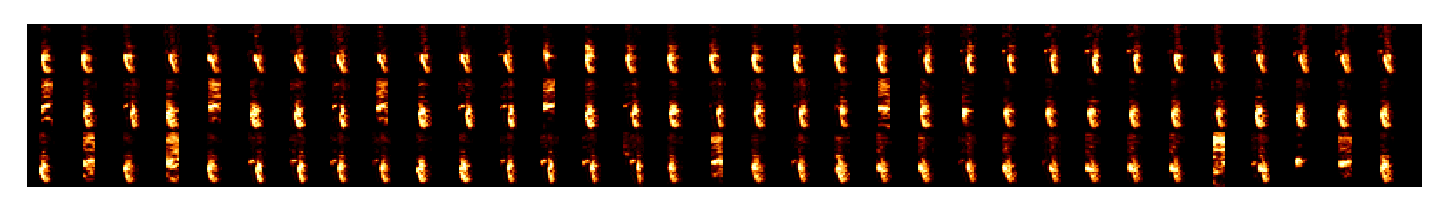

15


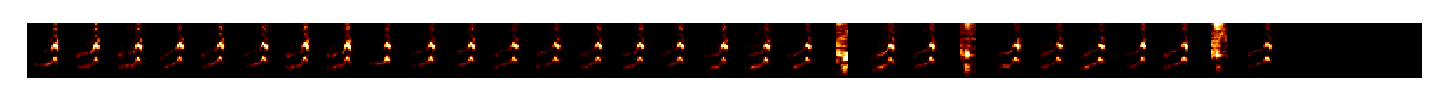

10


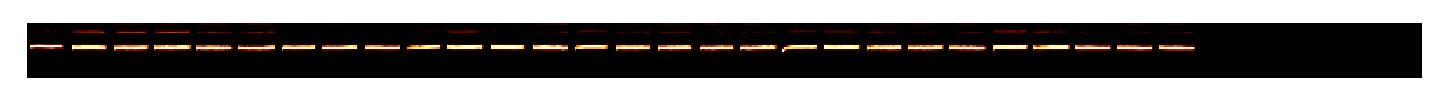

12


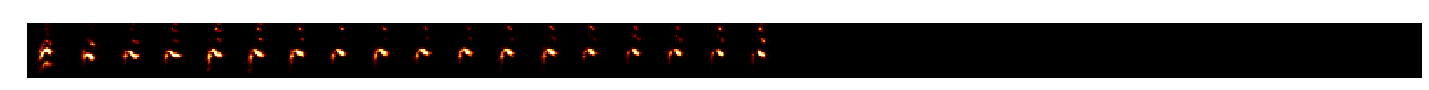

In [16]:
for indv in tqdm(syllable_df.indv.unique()):
    indv_df = syllable_df[syllable_df.indv == indv]
    indv_df = indv_df.sort_values(by=["key", "start_time"])
    print(indv, len(indv_df))
    indv_df = indv_df[:20000]
    for phrase in tqdm(indv_df.phrase.unique(), leave=False):
        print(phrase)
        specs = list(indv_df[indv_df.phrase == phrase].spectrogram.values)
        draw_spec_set(specs, zoom=1, maxrows=3, colsize=25)
    break

In [17]:
def norm(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

### cluster

In [21]:
from cuml.manifold.umap import UMAP as cumlUMAP

In [22]:
from avgn.visualization.projections import scatter_spec
from avgn.utils.general import save_fig
from avgn.utils.paths import FIGURE_DIR, ensure_dir

In [23]:
ensure_dir(FIGURE_DIR / 'canary')

bird3 127752


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


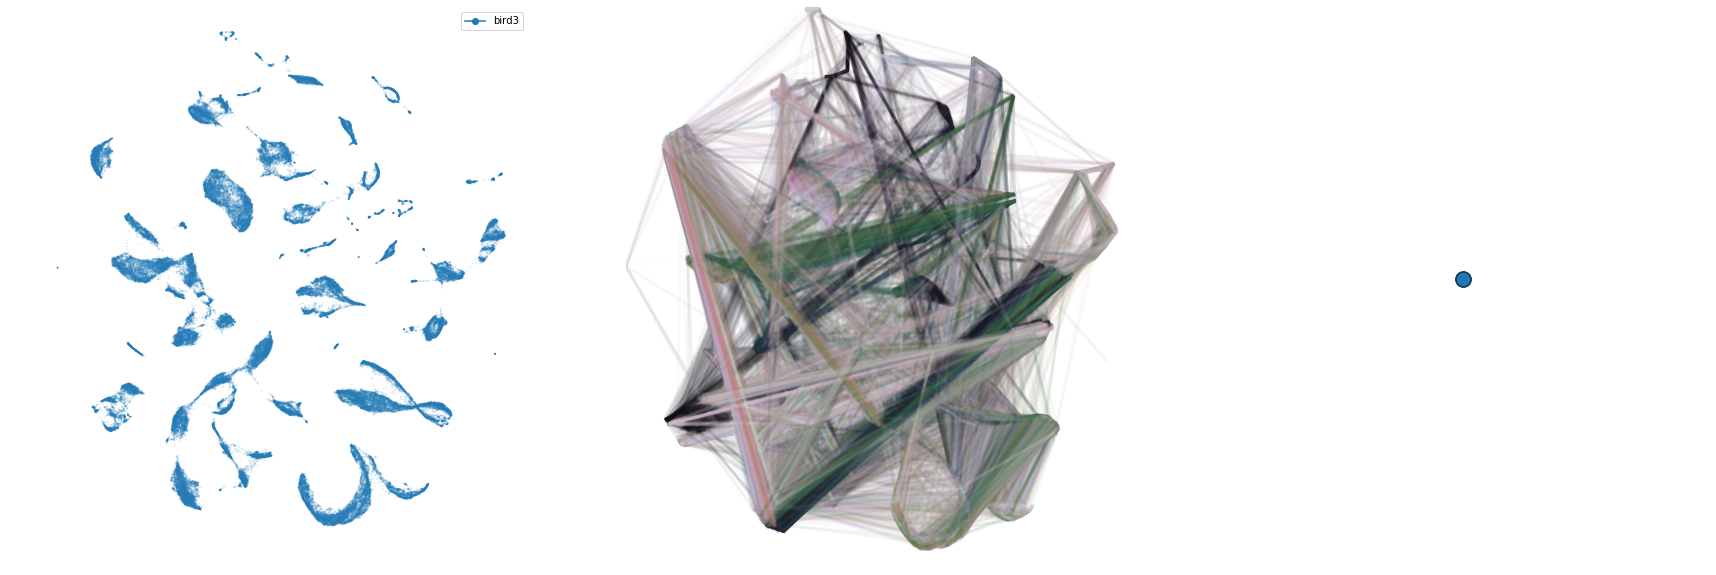

In [ ]:
for indv in tqdm(syllable_df.indv.unique()):
    indv_df = syllable_df[syllable_df.indv == indv]
    indv_df = indv_df.sort_values(by=["key", "start_time"])
    print(indv, len(indv_df))
    #indv_df = indv_df[:20000]
    specs = list(indv_df.spectrogram.values)
    #draw_spec_set(specs, zoom=1, maxrows=10, colsize=25)
    # umap
    specs_flattened = flatten_spectrograms(specs)
    #cuml_umap = cumlUMAP(min_dist=0.25)
    #z = list(cuml_umap.fit_transform(specs_flattened))
    fit = umap.UMAP()
    z = list(fit.fit_transform(specs_flattened))
    indv_df["umap"] = z
    
    # sequencing
    indv_df["syllables_sequence_id"] = None
    indv_df["syllables_sequence_pos"] = None
    for ki, key in enumerate(indv_df.key.unique()):
        indv_df.loc[indv_df.key == key, "syllables_sequence_id"] = ki
        indv_df.loc[indv_df.key == key, "syllables_sequence_pos"] = np.arange(
            np.sum(indv_df.key == key)
        )
        
    # plot
    draw_projection_plots(indv_df, label_column="indv")
    plt.show()
    
    scatter_spec(
        np.vstack(z),
        specs,
        column_size=15,
        #x_range = [-5.5,7],
        #y_range = [-10,10],
        pal_color="hls",
        color_points=False,
        enlarge_points=20,
        figsize=(10, 10),
        scatter_kwargs = {
            'labels': list(indv_df.phrase.values),
            'alpha':0.25,
            's': 1,
            'show_legend': False
        },
        matshow_kwargs = {
            'cmap': plt.cm.Greys
        },
        line_kwargs = {
            'lw':1,
            'ls':"solid",
            'alpha':0.25,
        },
        draw_lines=True
    );
    save_fig(FIGURE_DIR / 'canary'/ ('canary_' + indv), dpi=300, save_jpg=True)

    plt.show()
    
